In [63]:
from pkg_resources import non_empty_lines
%pip install -q peft datasets evaluate
%pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu130
%pip install -q transformers[torch]


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [64]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
from peft import get_peft_model, LoraConfig, TaskType
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

In [65]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
dataset = load_dataset("glue", "mrpc")
model_name_or_path = "roberta-base"
task = "mrpc"
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})


In [66]:
metric = evaluate.load("glue", task)

In [67]:
dataset["validation"][1]

{'sentence1': 'Magnarelli said Racicot hated the Iraqi regime and looked forward to using his long years of training in the war .',
 'sentence2': 'His wife said he was " 100 percent behind George Bush " and looked forward to using his years of training in the war .',
 'label': 0,
 'idx': 18}

In [68]:
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value('int64'), 'references': Value('int64')}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(results

In [69]:
references = [0, 1]
predictions = [1, 1]
results = metric.compute(predictions=predictions, references=references)
print(results)


{'accuracy': 0.5, 'f1': 0.6666666666666666}


In [70]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side = "right")

if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        truncation=True,
        max_length = None
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["sentence1", "sentence2"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

In [71]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['labels', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['labels', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [72]:
tokenized_datasets["train"][1]

{'labels': 0,
 'idx': 1,
 'input_ids': [0,
  975,
  26802,
  1588,
  102,
  2164,
  13976,
  1758,
  128,
  29,
  137,
  2183,
  5,
  3206,
  7,
  11881,
  10564,
  11,
  6708,
  13,
  68,
  132,
  4,
  245,
  325,
  479,
  2,
  2,
  975,
  26802,
  1588,
  102,
  2162,
  13976,
  1758,
  128,
  29,
  11,
  7969,
  13,
  68,
  231,
  6478,
  153,
  8,
  1088,
  24,
  7,
  11881,
  10564,
  13,
  68,
  112,
  4,
  398,
  325,
  11,
  6708,
  479,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [73]:
example_input_ids = tokenized_datasets['train'][0]['input_ids']
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(example_input_ids))



'<s>Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .</s></s>Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .</s>'

In [74]:
#from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")


In [75]:
#from transformers import AutoModelForSequenceClassification, TrainingArguments, trainer
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(sum(p.numel() for p in model.parameters()))
training_args = TrainingArguments(
    output_dir="./output",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy = "epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


124647170


In [76]:
from transformers import trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions = predictions, references = labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],  # or "test" if you prefer
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics= compute_metrics,
)

trainer.train()

C:\Users\Balle\AppData\Local\Temp\ipykernel_19752\3756462313.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.522800,0.361787,0.865196,0.898336
2,0.344100,0.309810,0.875000,0.908766


TrainOutput(global_step=230, training_loss=0.4156065899392833, metrics={'train_runtime': 46.9998, 'train_samples_per_second': 156.086, 'train_steps_per_second': 4.894, 'total_flos': 302442047026080.0, 'train_loss': 0.4156065899392833, 'epoch': 2.0})

In [77]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.30981001257896423, 'eval_accuracy': 0.875, 'eval_f1': 0.9087656529516994, 'eval_runtime': 0.7509, 'eval_samples_per_second': 543.327, 'eval_steps_per_second': 17.312, 'epoch': 2.0}


In [78]:
#from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#import matplotlib.pyplot as plt
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = np.argmax(trainer.predict(tokenized_datasets["test"]).predictions, axis=1)
y_test = tokenized_datasets["test"]['labels']

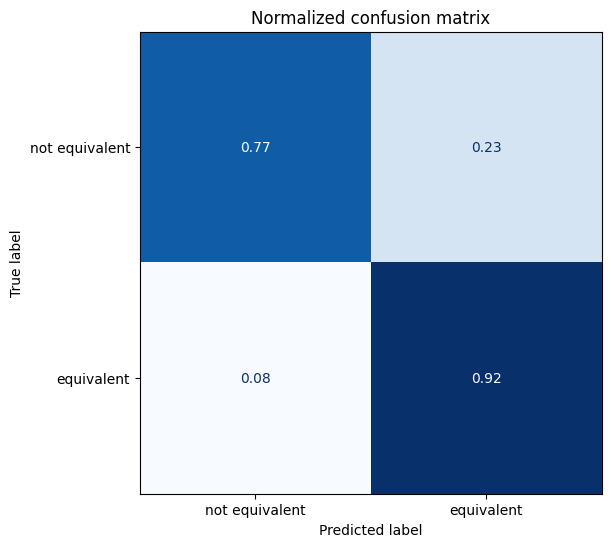

In [79]:
labels = ["not equivalent", "equivalent"]
plot_confusion_matrix(y_preds, y_test, labels)

In [80]:
print("y_preds shape:", np.shape(y_preds))
print("y_test shape:", np.shape(y_test))
print("Arrays are same length:", len(y_preds) == len(y_test))

# Check value ranges/classes
print("Unique values in y_preds:", np.unique(y_preds))
print("Unique values in y_test:", np.unique(y_test))

# Quick mismatch check (should be zero for identical arrays)
n_mismatches = np.count_nonzero(y_preds != y_test)
print("Number of mismatches between prediction and truth:", n_mismatches)
print("Train label distribution:", np.bincount(y_preds))
print("Test label distribution:", np.bincount(y_test))

y_preds shape: (1725,)
y_test shape: (1725,)
Arrays are same length: True
Unique values in y_preds: [0 1]
Unique values in y_test: [0 1]
Number of mismatches between prediction and truth: 224
Train label distribution: [ 540 1185]
Test label distribution: [ 578 1147]


In [81]:
from peft import LoraConfig
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,
    lora_alpha=1,
    lora_dropout=0.1)

In [83]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,771,778 || all params: 126,418,948 || trainable%: 1.4015


In [92]:
training_args = TrainingArguments(
    output_dir="./output/roberta-base-peft-p-tuning",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
)

In [93]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


C:\Users\Balle\AppData\Local\Temp\ipykernel_19752\621152119.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [94]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.346100,0.363657,0.838841,0.883389
2,0.325700,0.355804,0.841739,0.883978
3,0.314700,0.359153,0.842899,0.884828
4,0.321700,0.356013,0.843478,0.884812


TrainOutput(global_step=460, training_loss=0.33202809043552567, metrics={'train_runtime': 75.165, 'train_samples_per_second': 195.197, 'train_steps_per_second': 6.12, 'total_flos': 617951048233344.0, 'train_loss': 0.33202809043552567, 'epoch': 4.0})

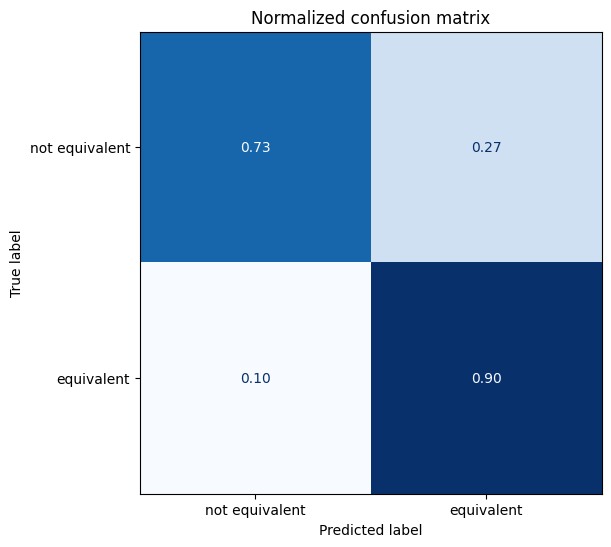

In [88]:
y_preds = np.argmax(trainer.predict(tokenized_datasets["test"]).predictions, axis=1)
y_test = tokenized_datasets["test"]['labels']
labels = ["not equivalent", "equivalent"]
plot_confusion_matrix(y_preds, y_test, labels)

In [90]:
def get_preds(sentence1, sentence2, classes=["not equivalent", "equivalent"]):
  inputs = tokenizer(sentence1,
                     sentence2,
                     truncation=True,
                     padding="longest",
                     return_tensors="pt").to("cuda")
  with torch.no_grad():
    outputs = trainer.model(**inputs).logits
    print(outputs)

  paraphrased_text = torch.softmax(outputs, dim=1).tolist()[0]
  for i in range(len(classes)):
      print(f"{classes[i]}: {int(round(paraphrased_text[i] * 100))}%")
sentence1 = "Coast redwood trees are the tallest trees on the planet and can grow over 300 feet tall."
sentence2 = "The coast redwood trees, which can attain a height of over 300 feet, are the tallest trees on earth."
get_preds(sentence1, sentence2)

tensor([[-2.3737,  2.2976]], device='cuda:0')
not equivalent: 1%
equivalent: 99%


In [91]:
sentence1 = 'Howdy, my name is Harry and I like data science'
sentence2 = 'Howdy, my name is Albert and I like mathematics'
get_preds(sentence1, sentence2)

tensor([[-0.3806,  0.2290]], device='cuda:0')
not equivalent: 35%
equivalent: 65%
